In [1]:
!pip install dipy
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 72.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 651.8 kB/s eta 0:00:00


In [2]:
import os
from google.colab import drive
mount_path = '/content/drive'
drive_path = mount_path+"/MyDrive/dti-transformer/code/model"
results_path = drive_path+"/results"
test_data = mount_path+'/MyDrive/dti-transformer/dti_data'
drive.mount(mount_path)
os.chdir(drive_path)

Mounted at /content/drive


In [3]:
# Daniel Bandala @ nov-2022
# dti-model validation script
# general libraries
import csv, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log10, sqrt
# diffussion image processing
from dipy.io.image import load_nifti
# import torch libraries
import torch 
from torch import nn
# import dataset auxiliar libraries
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from dti_model import DiffusionTensorModel
from other.unet import UNet
from data_loader import data_preprocessing, normalize_data
from torchvision.transforms import functional as TF

In [4]:
# set plot parameters
plt.rcParams.update({'font.size': 20})

In [17]:
signals = 7
maps = ["RGB"] #"MD","MO","L1","L2","L3",FA

In [18]:
# load model
checkpoint = torch.load(results_path+'/dti_rgb.weights') #dti_fa.weights FA_2023-03-30
model = DiffusionTensorModel(
    in_chans=signals,
    out_chans=3,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# use model in cpu for validation (gpu for training)
_ = model.to('cpu')
_ = model.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = model.eval()

In [19]:
# load unet model
weights = torch.load(results_path+'/unet/dti_rgb.weights')
unet = UNet(
    enc_channels=(signals,64,128,256,512,1024),
    dec_channels=(1024,512,256,128,64),
    out_chans=3,
    img_size=140
)
# use model in cpu for validation (gpu for training)
_ = unet.to('cpu')
_ = unet.load_state_dict(weights) #torch.load(, map_location=torch.device('cpu'))
_ = unet.eval()

In [20]:
test_list = [test_data+'/HCP/test/case_12',
              test_data+'/HCP/test/case_14',
              test_data+'/HCP/test/case_31',
              test_data+'/ADNI/test/case_13',
              test_data+'/ADNI/test/case_14',
              test_data+'/ADNI/test/case_30',
             ]

In [27]:
case_num = 2
data_eval, label_eval = data_preprocessing(test_list[case_num], maps=maps, signals=signals, dti_folder='output')
print("Input data shape: ", data_eval.shape)

Input data shape:  torch.Size([96, 7, 140, 140])


In [28]:
# read fsl data
output_fsl,_ = load_nifti(os.path.join(test_list[case_num],'fsl','DTI_RGB.nii.gz'))
output_fsl =  np.array(output_fsl.transpose(2,3,0,1),dtype=np.float32)
output_fsl = torch.tensor(output_fsl)
output_fsl = normalize_data(output_fsl)
output_fsl = TF.resize(output_fsl, (140, 140))
output_fsl = output_fsl.detach().numpy()

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [29]:
slice_idx = 49
### EVALUATE MODEL ###
data = data_eval[slice_idx]
label = label_eval[slice_idx]
label_np = label.detach().numpy()
# evaluate data with utnet model
with torch.no_grad():
    output = model(data)
output_model = output.detach().numpy()
mse = mean_squared_error(label_np, output_model)
ssim_v = ssim(label_np, output_model, data_range=label_np.max() - label_np.min(), channel_axis=0)
psnr = 20*log10(1/sqrt(mse))
# calculate error maps
error = label_np - output_model
error = np.abs(error)
# evaluate data with unet model
with torch.no_grad():
    output = unet(data)
output_unet = output.detach().numpy()
mse_unet = mean_squared_error(label_np, output_unet)
ssim_v_unet = ssim(label_np, output_unet, data_range=label_np.max() - label_np.min(), channel_axis=0)
psnr_unet = 20*log10(1/sqrt(mse_unet))
# evaluate data with conventional method
out_fsl = output_fsl[slice_idx]
mse_fsl = mean_squared_error(label_np, out_fsl)
ssim_v_fsl = ssim(label_np, out_fsl, data_range=label_np.max() - label_np.min(), channel_axis=0)
psnr_fsl = 20*log10(1/sqrt(mse_fsl))
# calculate error maps
error_unet = label_np - output_unet
error_unet = np.abs(error_unet)
error_fsl = label_np - out_fsl
error_fsl = np.abs(error_fsl)
# max error
max_error = np.max((error, error_unet, error_fsl))
# normalized error
y_mean = label_np.mean()
nmse = mse*100/y_mean
nmse_unet = mse_unet*100/y_mean
nmse_fsl = mse_fsl*100/y_mean
# print values for proposed model
print("NMSE: ",nmse)
print("SSIM: ",ssim_v)
print("PSNR: ",psnr)

NMSE:  4.379652086009796
SSIM:  0.8141579
PSNR:  26.442108150236624


<ipython-input-30-6b190d4cf711>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


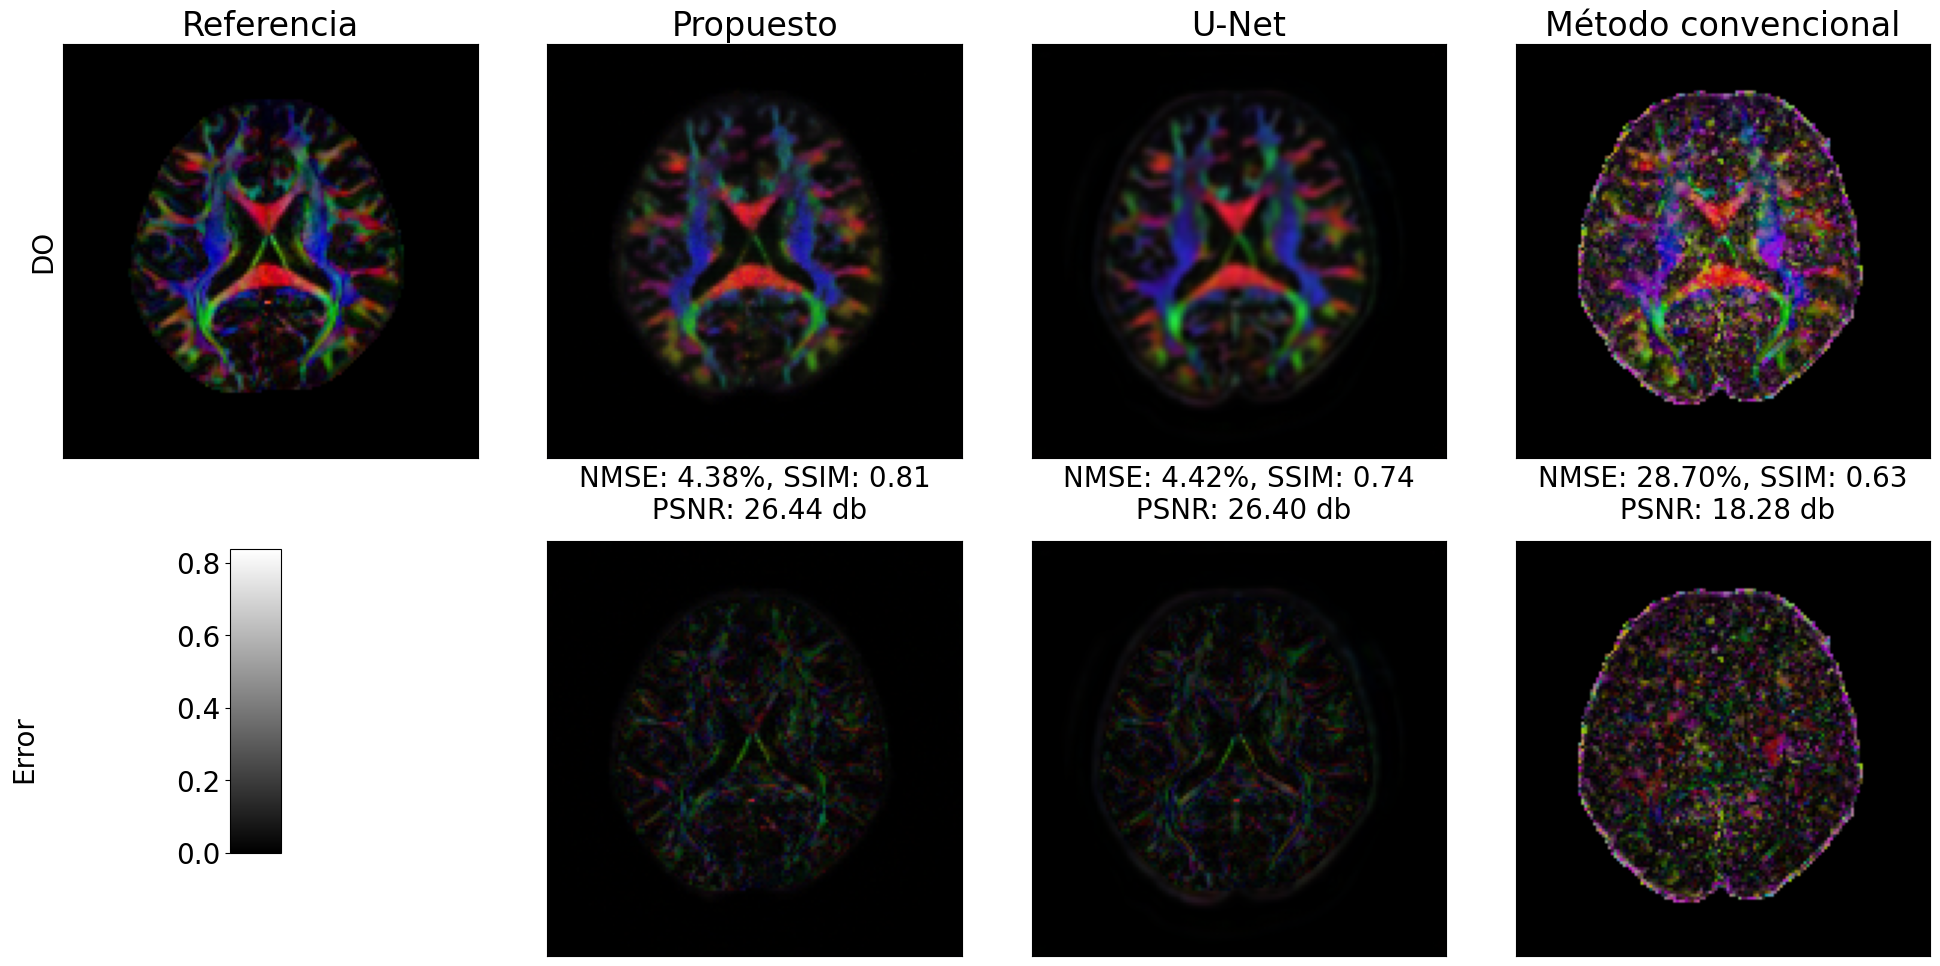

In [30]:
k_rot = 3
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(np.rot90(label_np.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[0].set_xlabel(f'')
ax[0].set_title('Referencia')
ax[0].set_ylabel("DO")
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax[1].imshow(np.rot90(output_model.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[1].set_xlabel(f'NMSE: {nmse:.2f}%, SSIM: {ssim_v:.2f}\n PSNR: {psnr:.2f} db')
ax[1].set_title('Propuesto')
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

ax[2].imshow(np.rot90(output_unet.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[2].set_xlabel(f'NMSE: {nmse_unet:.2f}%, SSIM: {ssim_v_unet:.2f}\n PSNR: {psnr_unet:.2f} db')
ax[2].set_title('U-Net')
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[3].imshow(np.rot90(out_fsl.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[3].set_xlabel(f'NMSE: {nmse_fsl:.2f}%, SSIM: {ssim_v_fsl:.2f}\n PSNR: {psnr_fsl:.2f} db')
ax[3].set_title('Método convencional')
ax[3].set_yticklabels([])
ax[3].set_xticklabels([])

ax[5].imshow(np.rot90(error.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray, vmin=0, vmax=max_error)
ax[5].set_xlabel(f'')
ax[5].set_yticklabels([])
ax[5].set_xticklabels([])

ax[6].imshow(np.rot90(error_unet.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray, vmin=0, vmax=max_error)
ax[6].set_xlabel(f'')
ax[6].set_yticklabels([])
ax[6].set_xticklabels([])

ax_bar = ax[7].imshow(np.rot90(error_fsl.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray, vmin=0, vmax=max_error)
ax[7].set_xlabel(f'')
ax[7].set_yticklabels([])
ax[7].set_xticklabels([])

# Hide axes ticks
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_xlabel(f'')
ax[4].set_ylabel("Error")
fig.colorbar(ax_bar, ax=[ax[4]], location='left', aspect=6)
#fig.colorbar(ax_bar, ax=[ax[4]], location='left', aspect=5, pad=.8)
ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[4].spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(results_path+f"/fa_result_{case_num}_{slice_idx}.png")
plt.show()